# Selfish Agent Analysis

Comparing Selfish, CFR, and Random agents in Secret Hitler.

In [1]:
import sys
from pathlib import Path

# Add paths
root = Path().absolute().parent.parent
sys.path.insert(0, str(root / "shitler_env"))
sys.path.insert(0, str(root / "agents"))
sys.path.insert(0, str(root / "agents" / "cfr"))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm  # Use regular tqdm instead of notebook version

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Import game and agents
from game import ShitlerEnv
from agent import SimpleRandomAgent, BaseAgent
import random
import pickle

## Agent Definitions

In [3]:
class SelfishAgent(BaseAgent):
    """Selfish agent - prioritizes own party's policies."""
    
    def get_action(self, obs, action_space=None, **kwargs):
        role = obs.get("role", 0)
        is_liberal = (role == 0)
        
        valid_actions = self.get_valid_actions(obs)
        
        if "card_action_mask" in obs:
            return self._selfish_card_action(obs, is_liberal)
        
        if valid_actions:
            return random.choice(valid_actions)
        
        if action_space:
            return action_space.sample()
        
        return 0
    
    def _selfish_card_action(self, obs, is_liberal):
        cards = obs.get("cards", [])
        mask = obs.get("card_action_mask", [1, 1])
        
        num_libs = 0
        for i, v in enumerate(cards):
            if v == 1:
                num_libs = i
                break
        
        total_cards = 3 if len(cards) == 4 else 2
        num_fascs = total_cards - num_libs
        
        valid = [i for i, v in enumerate(mask) if v == 1]
        
        if is_liberal:
            if 1 in valid and num_fascs > 0:
                return 1
            if 0 in valid and num_libs > 0:
                return 0
        else:
            if 0 in valid and num_libs > 0:
                return 0
            if 1 in valid and num_fascs > 0:
                return 1
        
        return random.choice(valid) if valid else 0

In [4]:
# CFR Agent (optional - only if checkpoint exists)
from infoset import get_infoset_key

class CFRAgent(BaseAgent):
    """CFR+ agent using trained strategy tables."""
    
    def __init__(self, checkpoint_path=None):
        self.regret_sums = defaultdict(lambda: defaultdict(float))
        self.strategy_sums = defaultdict(lambda: defaultdict(float))
        self.iterations = 0
        
        if checkpoint_path:
            self.load_checkpoint(checkpoint_path)
    
    def load_checkpoint(self, path):
        with open(path, "rb") as f:
            data = pickle.load(f)
        
        self.iterations = data.get("iterations", 0)
        
        for k, v in data["regret_sums"].items():
            for a, r in v.items():
                self.regret_sums[k][a] = r
        
        for k, v in data["strategy_sums"].items():
            for a, s in v.items():
                self.strategy_sums[k][a] = s
        
        print(f"Loaded CFR: {self.iterations} iterations, {len(self.regret_sums)} infosets")
    
    def get_average_strategy(self, infoset_key, legal_actions):
        strat_sums = self.strategy_sums[infoset_key]
        total = sum(strat_sums[a] for a in legal_actions)
        
        if total > 0:
            return {a: strat_sums[a] / total for a in legal_actions}
        else:
            n = len(legal_actions)
            return {a: 1.0 / n for a in legal_actions}
    
    def sample_action(self, strategy):
        actions = list(strategy.keys())
        probs = [strategy[a] for a in actions]
        return random.choices(actions, weights=probs, k=1)[0]
    
    def get_action(self, obs, action_space=None, **kwargs):
        phase = kwargs.get("phase", None)
        
        if phase is None:
            if "nomination_mask" in obs:
                phase = "nomination"
            elif "execution_mask" in obs:
                phase = "execution"
            elif "card_action_mask" in obs:
                cards = obs.get("cards", [])
                phase = "prez_cardsel" if len(cards) == 4 else "chanc_cardsel"
            else:
                phase = "voting"
        
        # Hard-code liberal card selection
        if phase in ["prez_cardsel", "chanc_cardsel"]:
            mask = obs.get("card_action_mask", [1, 1])
            if mask[1] == 1:
                return 1
            return 0
        
        legal_actions = self.get_valid_actions(obs)
        if not legal_actions:
            if action_space:
                return action_space.sample()
            return 0
        
        agent_idx = kwargs.get("agent_idx", obs.get("president_idx", 0))
        infoset_key = get_infoset_key(obs, phase, agent_idx)
        
        strategy = self.get_average_strategy(infoset_key, legal_actions)
        return self.sample_action(strategy)

## Evaluation with Confidence Intervals

In [5]:
def play_game(liberal_agent, fascist_agent, seed=None):
    """Play a single game and return result."""
    env = ShitlerEnv()
    env.reset(seed=seed)
    
    # Map agents to players based on roles
    agents = {}
    for i, agent_name in enumerate(env.agents):
        role = env.roles[agent_name]
        if role == "lib":
            agents[agent_name] = liberal_agent
        else:
            agents[agent_name] = fascist_agent
    
    step = 0
    while not all(env.terminations.values()) and step < 1000:
        agent_name = env.agent_selection
        agent_idx = env.agents.index(agent_name)
        obs = env.observe(agent_name)
        action_space = env.action_space(agent_name)
        phase = env.phase
        
        action = agents[agent_name].get_action(
            obs, action_space, phase=phase, agent_idx=agent_idx
        )
        env.step(action)
        step += 1
    
    # Determine winner
    for agent_name, reward in env.rewards.items():
        if reward == 1:
            role = env.roles[agent_name]
            lib_win = (role == "lib")
            break
    else:
        lib_win = False
    
    # Win condition
    if lib_win:
        win_cond = "lib_5_policies" if env.lib_policies >= 5 else "hitler_executed"
    else:
        win_cond = "fasc_6_policies" if env.fasc_policies >= 6 else "hitler_chancellor"
    
    return {
        "lib_win": lib_win,
        "win_condition": win_cond,
        "lib_policies": env.lib_policies,
        "fasc_policies": env.fasc_policies,
        "steps": step,
    }

In [6]:
def evaluate_with_ci(liberal_agent, fascist_agent, num_games=1000, seed=42, confidence=0.95):
    """
    Evaluate agents and compute confidence interval for win rate.
    
    Uses Wilson score interval for binomial proportion.
    """
    from scipy import stats
    
    results = []
    for i in tqdm(range(num_games), desc="Playing games"):
        game_seed = seed + i if seed else None
        result = play_game(liberal_agent, fascist_agent, seed=game_seed)
        results.append(result)
    
    # Compute win rate
    lib_wins = sum(1 for r in results if r["lib_win"])
    win_rate = lib_wins / num_games
    
    # Wilson score interval
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    n = num_games
    p = win_rate
    
    denominator = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denominator
    
    ci_low = center - margin
    ci_high = center + margin
    
    # Win conditions
    win_conditions = defaultdict(int)
    for r in results:
        win_conditions[r["win_condition"]] += 1
    
    return {
        "lib_win_rate": win_rate,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "ci_margin": margin,
        "num_games": num_games,
        "lib_wins": lib_wins,
        "fasc_wins": num_games - lib_wins,
        "win_conditions": dict(win_conditions),
        "avg_lib_policies": np.mean([r["lib_policies"] for r in results]),
        "avg_fasc_policies": np.mean([r["fasc_policies"] for r in results]),
        "avg_steps": np.mean([r["steps"] for r in results]),
    }

## Run Experiments

In [7]:
# Create agents
random_agent = SimpleRandomAgent()
selfish_agent = SelfishAgent()

# Try to load CFR agent
cfr_checkpoint = root / "experiments" / "cfr" / "checkpoints" / "cfr_liberal_iter_350000.pkl"
if cfr_checkpoint.exists():
    cfr_agent = CFRAgent(checkpoint_path=str(cfr_checkpoint))
else:
    print(f"CFR checkpoint not found at {cfr_checkpoint}")
    cfr_agent = None

Loaded CFR: 350000 iterations, 3046252 infosets


In [16]:
NUM_GAMES = 16000
SEED = 42

experiments = {}

In [17]:
# 1. Random vs Random (baseline)
print("1. Random vs Random")
experiments["random_vs_random"] = evaluate_with_ci(
    random_agent, random_agent, num_games=NUM_GAMES, seed=SEED
)
print(f"   Lib win rate: {experiments['random_vs_random']['lib_win_rate']:.1%} "
      f"({experiments['random_vs_random']['ci_low']:.1%} - {experiments['random_vs_random']['ci_high']:.1%})")

1. Random vs Random


Playing games: 100%|██████████| 16000/16000 [00:32<00:00, 499.26it/s]

   Lib win rate: 50.2% (49.5% - 51.0%)


In [18]:
# 2. Selfish Lib vs Random Fasc
print("2. Selfish Lib vs Random Fasc")
experiments["selfish_lib_vs_random"] = evaluate_with_ci(
    selfish_agent, random_agent, num_games=NUM_GAMES, seed=SEED
)
print(f"   Lib win rate: {experiments['selfish_lib_vs_random']['lib_win_rate']:.1%} "
      f"({experiments['selfish_lib_vs_random']['ci_low']:.1%} - {experiments['selfish_lib_vs_random']['ci_high']:.1%})")

2. Selfish Lib vs Random Fasc


Playing games: 100%|██████████| 16000/16000 [00:32<00:00, 499.71it/s]

   Lib win rate: 49.8% (49.0% - 50.6%)


In [19]:
# 3. Random Lib vs Selfish Fasc
print("3. Random Lib vs Selfish Fasc")
experiments["random_lib_vs_selfish"] = evaluate_with_ci(
    random_agent, selfish_agent, num_games=NUM_GAMES, seed=SEED
)
print(f"   Lib win rate: {experiments['random_lib_vs_selfish']['lib_win_rate']:.1%} "
      f"({experiments['random_lib_vs_selfish']['ci_low']:.1%} - {experiments['random_lib_vs_selfish']['ci_high']:.1%})")

3. Random Lib vs Selfish Fasc


Playing games: 100%|██████████| 16000/16000 [00:29<00:00, 538.40it/s]


   Lib win rate: 28.2% (27.5% - 28.9%)


In [20]:
# 4. Selfish vs Selfish
print("4. Selfish vs Selfish")
experiments["selfish_vs_selfish"] = evaluate_with_ci(
    selfish_agent, selfish_agent, num_games=NUM_GAMES, seed=SEED
)
print(f"   Lib win rate: {experiments['selfish_vs_selfish']['lib_win_rate']:.1%} "
      f"({experiments['selfish_vs_selfish']['ci_low']:.1%} - {experiments['selfish_vs_selfish']['ci_high']:.1%})")

4. Selfish vs Selfish


Playing games: 100%|██████████| 16000/16000 [00:30<00:00, 531.11it/s]


   Lib win rate: 28.2% (27.5% - 28.9%)


In [21]:
# 5. CFR Lib vs Random Fasc (if available)
if cfr_agent:
    print("5. CFR Lib vs Random Fasc")
    experiments["cfr_lib_vs_random"] = evaluate_with_ci(
        cfr_agent, random_agent, num_games=NUM_GAMES, seed=SEED
    )
    print(f"   Lib win rate: {experiments['cfr_lib_vs_random']['lib_win_rate']:.1%} "
          f"({experiments['cfr_lib_vs_random']['ci_low']:.1%} - {experiments['cfr_lib_vs_random']['ci_high']:.1%})")

5. CFR Lib vs Random Fasc


Playing games: 100%|██████████| 16000/16000 [00:35<00:00, 447.37it/s]


   Lib win rate: 49.8% (49.1% - 50.6%)


In [22]:
# 6. CFR Lib vs Selfish Fasc (if available)
if cfr_agent:
    print("6. CFR Lib vs Selfish Fasc")
    experiments["cfr_lib_vs_selfish"] = evaluate_with_ci(
        cfr_agent, selfish_agent, num_games=NUM_GAMES, seed=SEED
    )
    print(f"   Lib win rate: {experiments['cfr_lib_vs_selfish']['lib_win_rate']:.1%} "
          f"({experiments['cfr_lib_vs_selfish']['ci_low']:.1%} - {experiments['cfr_lib_vs_selfish']['ci_high']:.1%})")

6. CFR Lib vs Selfish Fasc


Playing games: 100%|██████████| 16000/16000 [00:36<00:00, 442.89it/s]

   Lib win rate: 28.8% (28.1% - 29.5%)


## Visualization

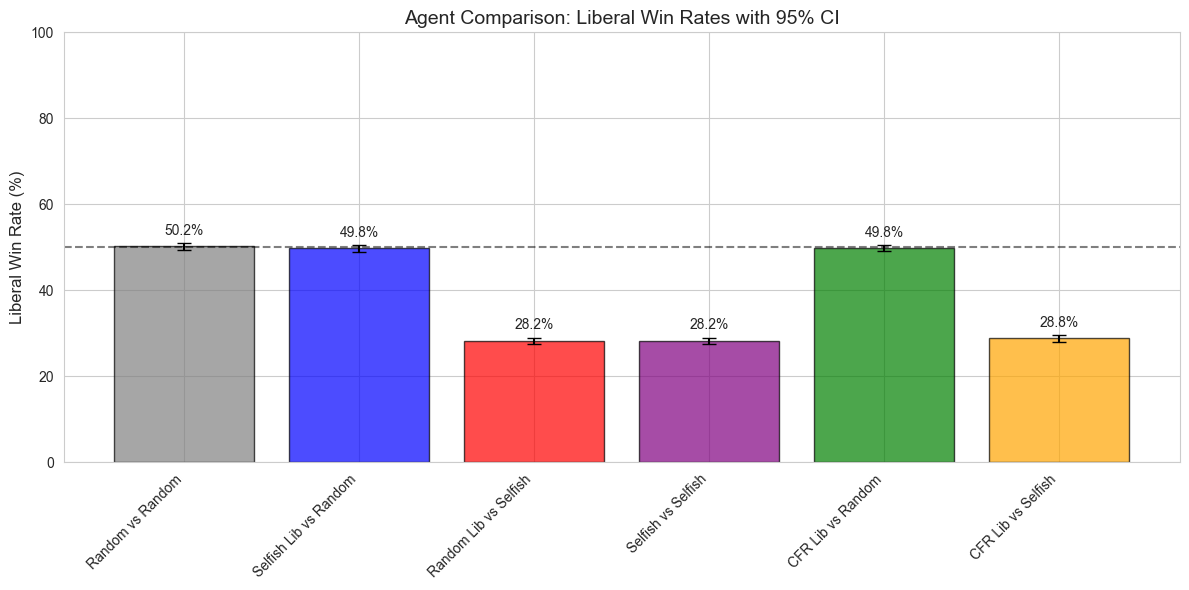

In [23]:
# Bar chart with confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))

labels = []
win_rates = []
ci_errors = []
colors = []

color_map = {
    "random_vs_random": "gray",
    "selfish_lib_vs_random": "blue",
    "random_lib_vs_selfish": "red",
    "selfish_vs_selfish": "purple",
    "cfr_lib_vs_random": "green",
    "cfr_lib_vs_selfish": "orange",
}

label_map = {
    "random_vs_random": "Random vs Random",
    "selfish_lib_vs_random": "Selfish Lib vs Random",
    "random_lib_vs_selfish": "Random Lib vs Selfish",
    "selfish_vs_selfish": "Selfish vs Selfish",
    "cfr_lib_vs_random": "CFR Lib vs Random",
    "cfr_lib_vs_selfish": "CFR Lib vs Selfish",
}

for key in ["random_vs_random", "selfish_lib_vs_random", "random_lib_vs_selfish", 
            "selfish_vs_selfish", "cfr_lib_vs_random", "cfr_lib_vs_selfish"]:
    if key in experiments:
        exp = experiments[key]
        labels.append(label_map[key])
        win_rates.append(exp["lib_win_rate"] * 100)
        ci_errors.append(exp["ci_margin"] * 100)
        colors.append(color_map[key])

x = np.arange(len(labels))
bars = ax.bar(x, win_rates, yerr=ci_errors, capsize=5, color=colors, alpha=0.7, edgecolor='black')

ax.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='50% baseline')
ax.set_ylabel('Liberal Win Rate (%)', fontsize=12)
ax.set_title('Agent Comparison: Liberal Win Rates with 95% CI', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar, rate in zip(bars, win_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('win_rates_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Win conditions breakdown
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (key, exp) in enumerate(experiments.items()):
    if idx >= 6:
        break
    ax = axes[idx]
    
    wc = exp["win_conditions"]
    conditions = list(wc.keys())
    counts = list(wc.values())
    
    colors_wc = ['green' if 'lib' in c or 'hitler_executed' in c else 'red' for c in conditions]
    ax.pie(counts, labels=conditions, autopct='%1.1f%%', colors=colors_wc, startangle=90)
    ax.set_title(label_map.get(key, key))

# Hide unused subplots
for idx in range(len(experiments), 6):
    axes[idx].axis('off')

plt.suptitle('Win Conditions Breakdown', fontsize=14)
plt.tight_layout()
plt.savefig('win_conditions.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary Table

In [ ]:
import pandas as pd

rows = []
for key, exp in experiments.items():
    rows.append({
        "Experiment": label_map.get(key, key),
        "Lib Win Rate": f"{exp['lib_win_rate']:.1%}",
        "95% CI": f"({exp['ci_low']:.1%} - {exp['ci_high']:.1%})",
        "Lib Wins": exp['lib_wins'],
        "Fasc Wins": exp['fasc_wins'],
        "Avg Lib Policies": f"{exp['avg_lib_policies']:.2f}",
        "Avg Fasc Policies": f"{exp['avg_fasc_policies']:.2f}",
        "Avg Steps": f"{exp['avg_steps']:.1f}",
    })

df = pd.DataFrame(rows)
df

## Statistical Significance Tests

In [ ]:
from scipy.stats import chi2_contingency

def compare_experiments(exp1_key, exp2_key):
    """Chi-square test for difference in win rates."""
    exp1 = experiments[exp1_key]
    exp2 = experiments[exp2_key]
    
    # Contingency table
    table = [
        [exp1['lib_wins'], exp1['fasc_wins']],
        [exp2['lib_wins'], exp2['fasc_wins']]
    ]
    
    chi2, p_value, dof, expected = chi2_contingency(table)
    
    diff = exp1['lib_win_rate'] - exp2['lib_win_rate']
    
    return {
        'exp1': label_map.get(exp1_key, exp1_key),
        'exp2': label_map.get(exp2_key, exp2_key),
        'diff': diff,
        'chi2': chi2,
        'p_value': p_value,
        'significant': p_value < 0.05,
    }

In [ ]:
# Compare key experiments
comparisons = [
    ("selfish_lib_vs_random", "random_vs_random"),
    ("random_lib_vs_selfish", "random_vs_random"),
    ("selfish_vs_selfish", "random_vs_random"),
]

if "cfr_lib_vs_random" in experiments:
    comparisons.extend([
        ("cfr_lib_vs_random", "random_vs_random"),
        ("cfr_lib_vs_random", "selfish_lib_vs_random"),
    ])

print("Statistical Significance Tests (α=0.05)")
print("=" * 70)
for exp1, exp2 in comparisons:
    if exp1 in experiments and exp2 in experiments:
        result = compare_experiments(exp1, exp2)
        sig = "*" if result['significant'] else ""
        print(f"{result['exp1']} vs {result['exp2']}:")
        print(f"  Difference: {result['diff']*100:+.1f}% | p-value: {result['p_value']:.4f} {sig}")
        print()

## Save Results

In [ ]:
import json
from datetime import datetime

# Save results to JSON
results_to_save = {}
for key, exp in experiments.items():
    results_to_save[key] = {
        "lib_win_rate": exp["lib_win_rate"],
        "ci_low": exp["ci_low"],
        "ci_high": exp["ci_high"],
        "num_games": exp["num_games"],
        "win_conditions": exp["win_conditions"],
    }

results_to_save["metadata"] = {
    "num_games": NUM_GAMES,
    "seed": SEED,
    "timestamp": datetime.now().isoformat(),
}

with open("results/analysis_results.json", "w") as f:
    json.dump(results_to_save, f, indent=2)

print("Results saved to results/analysis_results.json")